<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization-cells----run-this-first!" data-toc-modified-id="Initialization-cells----run-this-first!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization cells -- run this first!</a></span></li><li><span><a href="#Data-pre-processing-&amp;-visualization" data-toc-modified-id="Data-pre-processing-&amp;-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data pre-processing &amp; visualization</a></span><ul class="toc-item"><li><span><a href="#Visualizing-the-canonical-coordinates-in-2-D" data-toc-modified-id="Visualizing-the-canonical-coordinates-in-2-D-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualizing the canonical coordinates in 2-D</a></span></li><li><span><a href="#Visualizing-the-SVD-coordinates-in-2-D" data-toc-modified-id="Visualizing-the-SVD-coordinates-in-2-D-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualizing the SVD coordinates in 2-D</a></span></li></ul></li><li><span><a href="#Learning-a-linear-classifier" data-toc-modified-id="Learning-a-linear-classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning a linear classifier</a></span></li></ul></div>

# Initialization cells -- run this first!

In [1]:
using Plots, Interact, LinearAlgebra, Statistics
include("deps.jl")
gr(
    markerstrokewidth=0.3,
    markerstrokecolor=:white,
    alpha=0.7,
    label=""
)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16612424897274453778\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16942453045309530655\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16612424897274453778\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.GRBackend()

# Data pre-processing & visualization 

The goal of this problem is to design a linear classifer directly, via a least-squares formulation. 

Here we work with a medical dataset and try to determine if a patient has cancer or not based on the collection of certain attributes (see below).

The data is the the file `breast-cancer-wisconsin.data.txt`. We load the data using the command in the next cell.

In [2]:
using DelimitedFiles: readdlm
A = readdlm("breast-cancer-wisconsin.data.txt", ',');
@show size(A)

size(A) = (699, 11)


(699, 11)

The matrix $A$ is a $699 \times 11$ matrix.
The rows represent different patients ($=$ "samples");
the columns represent different attributes given below.

Column | Attribute | Type of data
-- | -- | -- |
1. | Sample code number |id number
2. | Clump Thickness |1 - 10
3. | Uniformity of Cell Size | 1 - 10
4. | Uniformity of Cell Shape | 1 - 10
5. | Marginal Adhesion | 1 - 10
6. | Single Epithelial Cell Size | 1 - 10
7. | Bare Nuclei | 1 - 10
8. | Bland Chromatin |1 - 10
9. | Normal Nucleoli | 1 - 10
10.| Mitoses |1 - 10
11.| Class | (2 for benign, 4 for malignant)


You can read more about the data [here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names).

Indeed! We ignore the entries corresponding to the `Class` label because that is the label we want to predict using the features corresponding to physical attributes on columns 2-10.

The training data set has the  `Class` label in it for our reference and we will use this to learn our classifier. When we are given a test vector, we will have to predict the label ("benign" or "malignant") from the 9 dimensional test vector containing information in the 9 physical attributes that remain once we omit the sample code. 

To that end, we will first pre-process the data by creating the $9 \times 699$ matrix `Adata` which contains information from the 2nd through 10th column of the original matrix - except now in the rows, as in the following cell. Consequently, the $i$-th column of `Adata` contains the 9 dimensional physical attribute for patient (or sample) $i$; thus there are 699 columns of `Adata` corresponding to the 699 patients.

We generate the matrix `Adata` via the command in the next cell.

In [3]:
Adata = transpose(A[:, 2:(end - 1)]);  #transpose the matrix so that the columns are different patients

We now obtain the labels for the benign and malignant cancer.

In [4]:
label_vector = A[:, end]
benign = findall(x -> x == 2, label_vector)
malignant = findall(x -> x == 4, label_vector);

## Visualizing the canonical coordinates in 2-D

We would like to visualize the data to determine whether the attributes help us disciminate between the `benign` and `malignant` categories. Of course we cannot visualize the entire feature vector because it is 9 dimensional and we cannot see objects in 9-D! 

To display the points in 2-D we will pick two distinct indices $k_1$ and $k_2$ and first display a 2-D scatter plot of the benign points `(Adata[k1, benign], Adata[k₂, benign])` -- note this corresponds to projecting the 9 dimensional vector onto the subspace spanned by $e_{k_1}$ and $e_{k_2}$. Then we will superimpose on this plot the 2-D scatter of    the malignant points `(Adata[k1, malignant], Adata[k₂, malignant])`. 

We will color code the plots different so we can tell which points  are which as in the next cell. 

In [5]:
@manipulate for k₁ in (1, 3, 5,7), k₂ in (2, 4, 6, 8)
    scatter(
        Adata[k₁, benign], Adata[k₂, benign]; 
        marker=:square,
        color=:red,
        label="benign",
        markersize=6
    ) 
    scatter!(
        Adata[k₁, malignant], Adata[k₂, malignant];
        marker=:circle,
        color=:green, 
        label="malignant",
        xlim=(0.5, 11),
        ylim=(0.5, 13),
        aspect_ratio=:equal
    ) 
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["k₁"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :span), Any[Node{DOM}(DOM(:html, :label), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text : key")))], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol,Any}(:attributes=>("data-bind"=>"foreach : options_js"),:className=>"buttons has-addons is-centered"))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[], Dict{Symbol,Any}())], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("options_js"=>(Observable{Any} with 1 listeners. Value:
OrderedDict[OrderedDict{String,Any}("key"=>"1","val"=>1,"id"=>"idP5xIx5KQ"), OrderedDict{String,Any}("key"=>"3","val"=>2,"id"=>"idJVZ7g5ek"), OrderedDict{String,Any}("key"=>"5","val"=>3,"id"=>"idhc2DMtxz"), OrderedDict{String,Any}("key"=>"7","val"=>4,"id"=>"idcEkbTSd2")], nothing),"index"=>(Observable{Any} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/nbuser/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/nbuser/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/nbuser/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/nbuser/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/nbuser/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("options_js"=>Any[JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Condition(Any[Task (runnable) @0x00007fcfba822230])), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"options_js\":WebIO.getval({\"name\":\"options_js\",\"scope\":\"10928032618110784692\",\"id\":\"ob_05\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":

## Visualizing the SVD coordinates in 2-D

We will now plot the "SVD coordinates'' of each sample (or patient) with respect to the top $k$ singular vectors.

This corresponds to computing and displaying the scatter plot corresponding to  

$$U[:,1:k]^H x_i,$$

for $k = 2$, where $x_i$ is the 9 dimensional sample vector and $U$ is the orthogonal matrix of the left singular vectors of `Adata`.

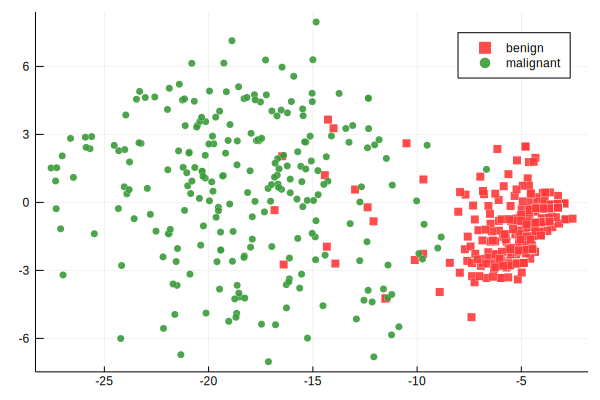

In [6]:
k = 2
U, s, V = svd(Adata)

Csvd = U[:, 1:k]' * Adata  # C is a k x # patients matrix of svd coordinates
scatter(Csvd[1, benign], Csvd[2, benign]; marker=:square, color=:red, label="benign") 
scatter!(Csvd[1, malignant], Csvd[2, malignant]; marker=:circle, color=:green, label="malignant") 


This  example demonstrates the utility of the SVD in producing discriminative features.  Our analysis of the scatter plot provides the insight for why we might expect a linear classifer learned on  the SVD coordinates to accurately (i.e. with probability) correctly discriminate between malignant and benign samples.

# Learning a linear classifier

Determine the weight and bias of linear classifer (with least squares loss) that separates the benign and malignant classes. We label the benign class as "+1" and the malignant class as "-1". 

Thus your classifier should return $w$ and $b$ which are solutions to the problem

\begin{equation}
\min_{w,b} \sum_{i \in \textrm{benign}} (w^T A[:,i] + b -\textrm{benign label})^2 +  \sum_{i \in \textrm{malignant}} (w^T A[:,i] + b - \textrm{malignant label})^2.
\end{equation}



**Exercise**:

Express Eq. (1)  as a least-squares problem of the form

\begin{equation}
w_{\sf LS}, b_{\sf LS} = \arg \min_{\widetilde{x}}  || \widetilde{A} x - \widetilde{b} \, ||_2^2,
\end{equation}

where

$$x = \begin{bmatrix} w \\ b \end{bmatrix}$$

and compute the least-square solution via the pseudo-inverse. 

Complete the function `ls_binary_classifier` using what you have derived. 

In [ ]:
using LinearAlgebra
function ls_binary_classifier(A::Matrix, labels_vector::Vector)
    
    class1 = findall(labels_vector .== 1)
    class2 = findall(labels_vector .== -1)
    
    A = vcat(A[:, class1]', A[:, class2]')
    Atil = hcat(A,ones(size(A,1)))
    btil = vcat(labels_vector[class1],  labels_vector[class2])
    
    x = pinv(Atil)*btil

    w = x[1 : end-1]
    b = x[end]
    
    return w, b 
end



The binary classification rule for a $\pm 1$ encoding is given by: 

$$\textrm{Class label } \hat{i} = \textrm{sign}(\hat{w}^T x + b - \tau),$$

where $\tau$ is the decision threshold.

In [8]:
label_vector[benign] .= -1.0
label_vector[malignant] .= 1.0;

In [9]:
function visualize_2d_linear_classifier(X::Matrix,w::Vector, b::Number, label_vector::Vector, τ::Number=0.0)
    
    x_lim = 1.25 .* extrema(X[1, :])
    xrange = range(x_lim[1]; stop=x_lim[2], length=200)
    
    y_lim = 1.25 .* extrema(X[2, :])

    yrange = range(y_lim[1]; stop=y_lim[2], length=200)
    
    Decision_xy = [sign.(x1 * what[1] + y1 * what[2] + bhat .- τ) for x1 in xrange, y1 in yrange]
   
    return Decision_xy, xrange, yrange
end

visualize_2d_linear_classifier (generic function with 2 methods)

We now compute the linear classifier via least-squares. 

In [10]:
what, bhat = ls_binary_classifier(Csvd, label_vector)

([-0.122867, 0.0209336], -1.475622928497561)

We display the decision boundary.

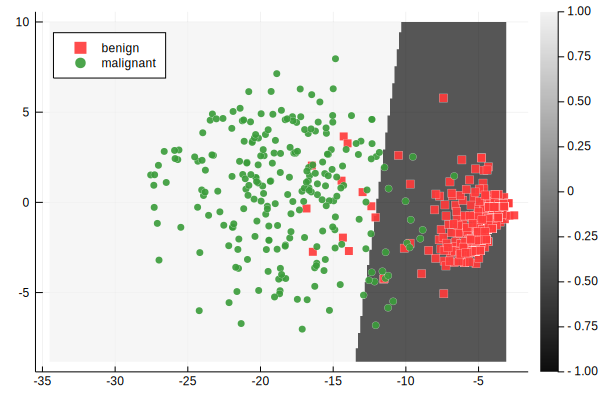

In [12]:
τ = 0.0
Decision_xy, xrange, yrange = visualize_2d_linear_classifier(Csvd, what, bhat, label_vector, τ)
heatmap(xrange, yrange, Decision_xy, transpose=:true, color=:grays)
scatter!(Csvd[1, benign], Csvd[2, benign]; marker=:square, color =:red, label="benign") 
scatter!(Csvd[1, malignant], Csvd[2, malignant]; marker=:circle, color=:green, label="malignant", legend=:topleft) 

We now compute the probability of correct detection and the probability of a false positive.  

**Exercise**:

Write a function to return the probability of correct detection and the probabilty of a false alarm.

In [18]:
function compute_linear_classifier_stats(X::Matrix, w::Vector, b::Number, label_vector::Vector, τ::Number=0.0)
    label_est = sign.(w' * X .+ b .- τ)
         
    P_correct = mean(label_est[label_vector .== 1] .== 1) ## the correct label is 1 and is classified as ??
    P_falsealarm = mean(label_est[label_vector .== -1] .== 1)   ## the correct label is =1 and is classified as ??
   
    return P_correct, P_falsealarm
end

compute_linear_classifier_stats (generic function with 2 methods)

In [19]:
τ = 0.0
P_correct = compute_linear_classifier_stats(Csvd, what, bhat, label_vector, τ)[1]
println("The probability of correctly diagnosing cancer is $P_correct") 

The probability of correctly diagnosing cancer is 0.91701244813278


In [22]:
τ = 0.0
P_falsealarm = compute_linear_classifier_stats(Csvd, what, bhat, label_vector, τ)[2]
println("The probability of falsely giving a diagnois of cancer is $P_falsealarm") 

The probability of falsely giving a diagnois of cancer is 0.021834061135371178


We now display the decision boundary and the statistics we just computed, as below.

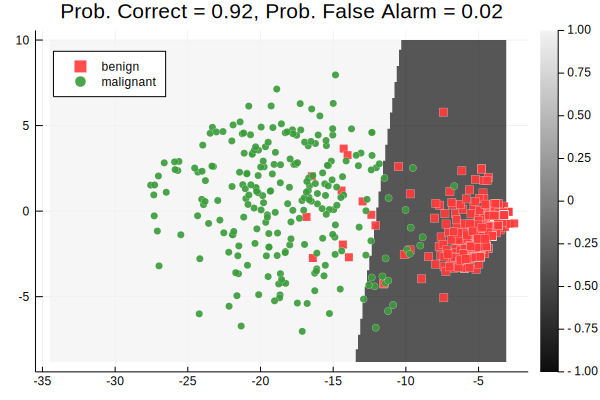

In [23]:
title!("Prob. Correct = $(round(P_correct; digits=2)), Prob. False Alarm = $(round(P_falsealarm; digits=2))")

Next we examine how the probability of correctly diagnosing a patient with cancer and the probability of incorrectly diagnoising a cancer-free patient as having cancer varies with the threshold $\tau$. 

In [26]:
@manipulate for τ = (-0.5, -0.25, 0.0, 0.25, 0.5)
    
    Decision_xy, xrange, yrange = visualize_2d_linear_classifier(Csvd, what, bhat, label_vector, τ)
    heatmap(xrange, yrange, Decision_xy, transpose =:true, color=:grays)
    scatter!(Csvd[1, benign], Csvd[2, benign]; marker=:square, color=:red, label="benign") 
    scatter!(Csvd[1, malignant], Csvd[2, malignant]; marker=:hexagon, color=:green, label="malignant", legend=:topleft) 
    
    P_correct, P_falsealarm = compute_linear_classifier_stats(Csvd, what, bhat, label_vector, τ)
    title!("Prob. Correct = $(round(P_correct; digits=2)), Prob. False Alarm = $(round(P_falsealarm; digits=2))")
    
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["τ"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :span), Any[Node{DOM}(DOM(:html, :label), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text : key")))], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"click: function (){\$root.update(val)}, css: {'is-primary is-selected' : \$root.index() == val, 'interact-widget is-medium button ' : true}")))], Dict{Symbol,Any}(:attributes=>("data-bind"=>"foreach : options_js"),:className=>"buttons has-addons is-centered"))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[], Dict{Symbol,Any}())], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("options_js"=>(Observable{Any} with 1 listeners. Value:
OrderedDict[OrderedDict{String,Any}("key"=>"-0.5","val"=>1,"id"=>"idafkre2V5"), OrderedDict{String,Any}("key"=>"-0.25","val"=>2,"id"=>"idMUvanpVX"), OrderedDict{String,Any}("key"=>"0.0","val"=>3,"id"=>"id3qUThMmM"), OrderedDict{String,Any}("key"=>"0.25","val"=>4,"id"=>"idvSa7aYTT"), OrderedDict{String,Any}("key"=>"0.5","val"=>5,"id"=>"idvEiZtMLB")], nothing),"index"=>(Observable{Any} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/nbuser/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/nbuser/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/nbuser/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/nbuser/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/nbuser/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("options_js"=>Any[JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Condition(Any[Task (runnable) @0x00007fcf94c670d0])), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"options_js\":WebIO.getval({\"name\":\"options_js\",\"scope\":\"4528265990899280919\",\"id\":\"ob_43\",\"